# Pink Crystal Model

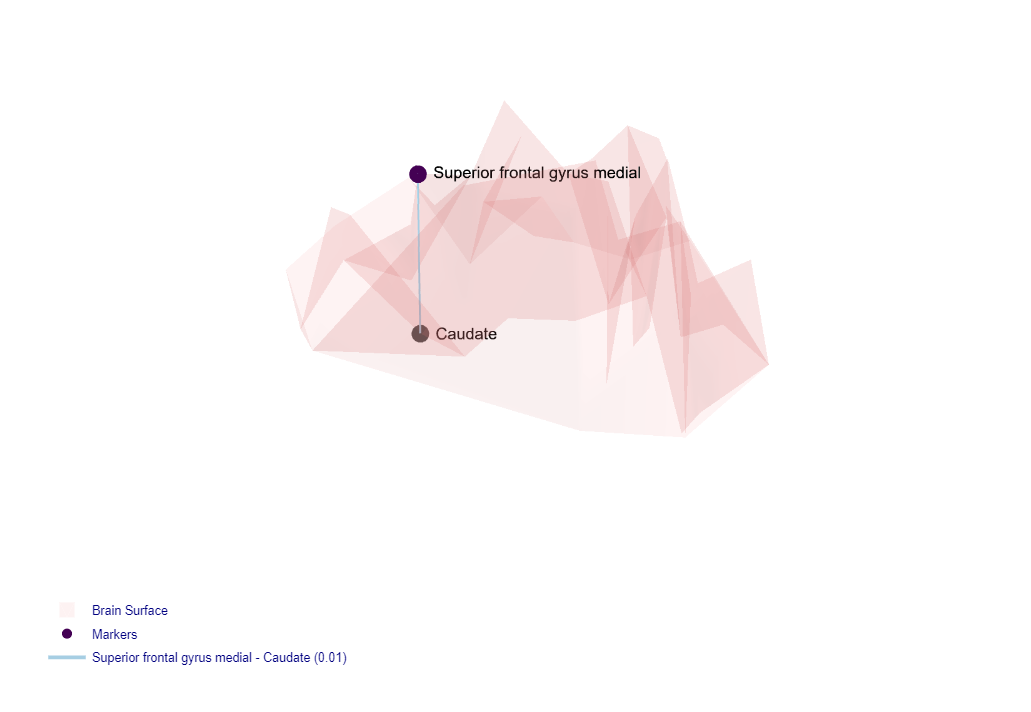

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import matplotlib.patches as mpatches
from matplotlib import colormaps, colors
from nilearn import datasets, plotting

### **Load Data**

In [63]:

# Load the Atlas File

dim = 64
difumo = datasets.fetch_atlas_difumo(dimension=dim, resolution_mm=2, legacy_format=False)

atlas_filename = difumo.maps
difumo_labels = difumo.labels

marker_labels = difumo_labels['difumo_names'].tolist() 

In [64]:
# grab center coordinates for probabilistic atlas
coords = plotting.find_probabilistic_atlas_cut_coords(
    maps_img=difumo.maps)

In [65]:
# Create a dictionary with the data
data = {
    'Feature Name': [
        'Superior frontal gyrus medial - Caudate',
        'Superior temporal sulcus with angular gyrus - Postcentral gyrus LH',
        'Inferior occipital gyrus - Superior parietal lobule',
        'Superior parietal lobule anterior - Parieto-occipital sulcus anterior',
        'Superior frontal gyrus medial - Dorsomedial prefrontal anterior-superior'
    ],
    'Importance Score': [
        0.005596,
        0.004884,
        0.004799,
        0.004279,
        0.004218
    ]
}

# Create the DataFrame
df = pd.DataFrame(data)

# Display the DataFrame
print(df)


                                        Feature Name  Importance Score
0            Superior frontal gyrus medial - Caudate          0.005596
1  Superior temporal sulcus with angular gyrus - ...          0.004884
2  Inferior occipital gyrus - Superior parietal l...          0.004799
3  Superior parietal lobule anterior - Parieto-oc...          0.004279
4  Superior frontal gyrus medial - Dorsomedial pr...          0.004218


In [66]:
# Functions

def transform_df(df):
    """
    Transform the DataFrame by splitting the 'Feature Name' column into 'Marker1' and 'Marker2',
    dropping the original 'Feature Name' column, renaming 'Importance Score' to 'Correlation',
    and returning the transformed DataFrame.
    
    Parameters:
    df (pd.DataFrame): The input DataFrame with columns 'Feature Index', 'Feature Name', and 'Importance Score'.
    
    Returns:
    pd.DataFrame: The transformed DataFrame with columns 'Feature Index', 'Marker1', 'Marker2', and 'Correlation'.
    """
    
    # Ensure 'Feature Name' column exists
    if 'Feature Name' not in df.columns or 'Importance Score' not in df.columns:
        raise ValueError("Input DataFrame must contain 'Feature Name' and 'Importance Score' columns.")
    
    # Split `Feature Name` into `Marker1` and `Marker2`
    df[['Marker1', 'Marker2']] = df['Feature Name'].str.split(' - ', n=1, expand=True)
    
    # Drop the 'Feature Name' column
    df = df.drop(columns=['Feature Name'])
    
    # Rename 'Importance Score' to 'Correlation'
    df = df.rename(columns={'Importance Score': 'Correlation'})
    
    return df



In [68]:
marker_corr = transform_df(df)

df = marker_corr


# Crystal Connectome

In [198]:
import numpy as np
import pandas as pd
import plotly.graph_objects as go
from scipy.spatial import Delaunay  # Import Delaunay for triangulation
import matplotlib.pyplot as plt
import matplotlib.colors as colors

def visualize_white_connectome_with_surface_final(df_sorted, coords, marker_labels, cmap_markers='viridis', cmap_edges='Paired'):
    """
    Visualizes a connectome on a fixed 3D surface using Plotly.
    
    Parameters:
    - df_sorted: DataFrame containing correlations between markers.
    - coords: Array of coordinates for the markers.
    - marker_labels: Labels for the markers.
    - cmap_markers: Colormap for the marker colors.
    - cmap_edges: Colormap for the edge colors.
    """

    vertices = coords  # Use the given coordinates for the surface

    # Create a Plotly figure
    fig = go.Figure()

    # Normalize correlations for color mapping
    norm = colors.Normalize(vmin=df_sorted['Correlation'].min(), vmax=df_sorted['Correlation'].max())
    cmap_markers = plt.colormaps[cmap_markers]
    cmap_edges = plt.colormaps[cmap_edges]

    # Triangulate the surface mesh using Delaunay triangulation
    if vertices.shape[0] >= 3:  # Ensure we have enough points to form a surface
        tri = Delaunay(vertices[:, :2])  # Use only the x and y coordinates for triangulation

        fig.add_trace(go.Mesh3d(
            x=vertices[:, 0],
            y=vertices[:, 1],
            z=vertices[:, 2],
            color='lightcoral',  # Light color for the surface
            opacity=0.1,  # Adjust opacity for visibility (lower for more transparency)
            i=tri.simplices[:, 0],
            j=tri.simplices[:, 1],
            k=tri.simplices[:, 2],
            name='Brain Surface',  # Name for legend
            showlegend=True  # Show in legend
        ))

    # Ensure marker_labels is a list
    if isinstance(marker_labels, pd.Index):
        marker_labels = marker_labels.tolist()

    # Extract unique markers from the top rows
    unique_markers = pd.unique(df_sorted[['Marker1', 'Marker2']].values.ravel('K'))

    # Filter marker labels and coordinates to only include those in unique_markers
    filtered_indices = [i for i, label in enumerate(marker_labels) if label in unique_markers]
    filtered_coords = coords[filtered_indices]
    filtered_labels = [marker_labels[i] for i in filtered_indices]

    # Add nodes to the plot
    fig.add_trace(go.Scatter3d(
        x=filtered_coords[:, 0],
        y=filtered_coords[:, 1],
        z=filtered_coords[:, 2],
        mode='markers+text',
        marker=dict(size=8, color=[colors.to_hex(cmap_markers(norm(c))) for c in df_sorted['Correlation']]),
        text=filtered_labels,
        textfont=dict(color='black', size=13, family="Arial"),  # Changed text color to black
        textposition='middle right',
        name='Markers'
    ))

    # Add edges to the plot
    for i, row in df_sorted.iterrows():
        marker1 = row['Marker1']
        marker2 = row['Marker2']
        correlation = row['Correlation']

        marker1_idx = filtered_labels.index(marker1)
        marker2_idx = filtered_labels.index(marker2)

        fig.add_trace(go.Scatter3d(
            x=[filtered_coords[marker1_idx, 0], filtered_coords[marker2_idx, 0]],
            y=[filtered_coords[marker1_idx, 1], filtered_coords[marker2_idx, 1]],
            z=[filtered_coords[marker1_idx, 2], filtered_coords[marker2_idx, 2]],
            mode='lines',
            line=dict(color=colors.to_hex(cmap_edges(norm(correlation))), width=3),
            name=f"{marker1} - {marker2} ({correlation:.2f})"
        ))

    # Update layout
    fig.update_layout(
        title=dict(
            text='',
            x=0.5,
            y=0.95,
            font=dict(size=22, color='navy', family="Roboto", weight='bold')  # Changed title color to navy blue
        ),
        paper_bgcolor='white',  # Changed background to white
        plot_bgcolor='white',   # Changed plot background to white
        scene=dict(
            xaxis=dict(
                title=dict(text='', font=dict(size=18, color='navy')),  # Changed axes title color to navy
                showbackground=False,
                showgrid=False,  # Disable grid
                showline=False,
                linecolor='navy',  # Change axis line color to navy
                showticklabels=False,
                zeroline=False
            ),
            yaxis=dict(
                title=dict(text='', font=dict(size=18, color='navy')),  # Changed axes title color to navy
                showbackground=False,
                showgrid=False,  # Disable grid
                showline=False,
                linecolor='navy',  # Change axis line color to navy
                showticklabels=False,
                zeroline=False
            ),
            zaxis=dict(
                title=dict(text='', font=dict(size=18, color='navy')),  # Changed axes title color to navy
                showbackground=False,
                showgrid=False,  # Disable grid
                showline=False,
                linecolor='navy',  # Change axis line color to navy
                showticklabels=False,
                zeroline=False
            )
        ),
        margin=dict(
            l=20,
            r=20,
            b=20,
            t=20
        ),
        width=800,
        height=600,
        showlegend=True,
        legend=dict(
            x=0.0,
            y=-0.2,
            font=dict(size=10, color='navy', family="Arial"),  # Changed legend text color to navy
            bgcolor='rgba(255, 255, 255, 0)',  # Changed legend background to transparent
        )
    )

    # Show the plot
    fig.show()

# Example usage
# df_sorted = pd.DataFrame(...)  # Load or create your DataFrame with correlations and markers
# coords = np.array(...)  # Load or create your array of coordinates
# marker_labels = [...]  # Load or create your list of marker labels
# visualize_connectome_with_surface_final(df_sorted, coords, marker_labels)


In [211]:
visualize_white_connectome_with_surface_final(df.head(1), coords, marker_labels, cmap_markers='viridis', cmap_edges='Paired')